In [64]:
# https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/

# import the necessary packages
import numpy as np
import argparse
import time
import cv2
import os
import random
import matplotlib.pyplot as plt
# construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
#     help="path to input image")
# ap.add_argument("-y", "--yolo", required=True,
#     help="base path to YOLO directory")
# ap.add_argument("-c", "--confidence", type=float, default=0.5,
#     help="minimum probability to filter weak detections")
# ap.add_argument("-t", "--threshold", type=float, default=0.3,
#     help="threshold when applying non-maxima suppression")
# args = vars(ap.parse_args())

In [65]:
# load our input image and grab its spatial dimensions
imgPath = './object_data/'
imgList = [i for i in os.listdir(imgPath) if 'jpeg' in i]

In [94]:
# load the COCO class labels our YOLO model was trained on
labelsPath = './coco.names'
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# derive the paths to the YOLO weights and model configuration
# download weughts file from https://pjreddie.com/darknet/yolo/
weightsPath = './yolo/yolov3-spp.weights'
configPath = './yolo/yolov3-spp.cfg'
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


[INFO] YOLO took 0.218080 seconds
2 cell phone: 0.8455
0 cell phone: 0.6156


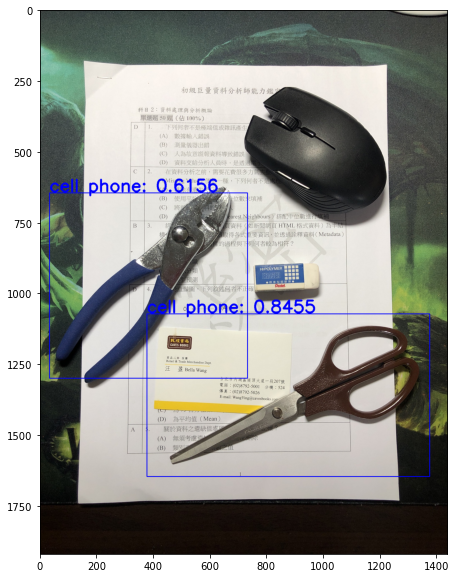

In [110]:
fname = random.choice(imgList)
image = cv2.imread(os.path.join(imgPath, fname))

(H, W) = image.shape[:2]
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (256, 416),
    swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
confidence_args = 0.5
threshold_args = 0.3

boxes = []
confidences = []
classIDs = []

# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        # extract the class ID and confidence (i.e., probability) of
        # the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > confidence_args:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")
            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)
            
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_args,
    threshold_args)

# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        # draw a bounding box rectangle and label on the image
        color = (255, 0, 0)# [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        print(i, text)
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            2, color, 5)
# show the output image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

